# Inland Water Body Detection: Machine Learning Approach

## Problem Description

**Core Challenge**  
Accurate detection of inland water bodies (lakes, rivers, wetlands) from satellite imagery is critical for environmental monitoring, flood prediction, and water resource management. Traditional methods like NDWI.

**Solution Approach**  
This project implements a dual-methodology framework:

| Method | Bands Used | Key Innovation | Use Case |
|--------|------------|----------------|----------|
| **NDWI** | B03 (Green), B08 (NIR) | Dynamic thresholding (0.0-0.3) | Baseline comparison |
| **K-means Clustering** | B02, B03, B04, B08 + NDWI | Automated cluster selection via NDWI validation | Complex water bodies |

### NDWI (Normalized Difference Water Index) Formula

The NDWI is calculated using Sentinel-2 reflectance values as:

$$
\text{NDWI} = \frac{{\text{Green}} - {\text{NIR}}}{{\text{Green}} + {\text{NIR}}}
$$

Where:
- ${\text{Green}}$ = Surface reflectance in green band (Sentinel-2 Band 3: 560nm)
- ${\text{NIR}}$ = Surface reflectance in near-infrared band (Sentinel-2 Band 8: 842nm)

---

## Objective  
This project employs unsupervised k-means classification augmented by NDWI spectral analysis to detect inland water bodies from Sentinel-2 satellite imagery. The investigation focuses on two distinct sediment-rich coastal environments:  
- Locate1: **Qiongzhou Strait/Beibu Gulf region** (characterized by turbid waters and limited paddy fields)  
- Locat2: **Haikou coastal zone** (featuring dense small lakes and urban interfaces)  

The integration of NDWI within the clustering framework aims to overcome limitations of conventional water detection approaches in these complex hydrodynamic environments.  


## Technical Challenges  
The high sediment loads in both study areas induce fundamental limitations in standard NDWI applications, where traditional thresholds frequently fail to distinguish turbid waters from moist soils due to spectral reflectance shifts. Seasonal NDWI variability between wet and dry periods introduces additional classification uncertainties, particularly through spectral confusion between natural water bodies and agricultural features in the Beibu Gulf region. Boundary effects in sub-resolution water features create transitional zones where mixed pixels challenge discrete classification, while urban shadows in Haikou generate false water signatures. These complexities are compounded by gradual NDWI transitions at water-land interfaces that blur categorical distinctions, necessitating a multi-feature clustering approach that dynamically incorporates spectral bands and water indices while leveraging NDWI's spatial gradient properties for boundary refinement.

In [ ]:
! pip install rasterio
! pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 76.3 MB/s eta 0:00:00


#Locate1 Water Body Performance Analysis
This script automatically traverses each subdirectory within a specified data directory to locate the Sentinel-2 **B02 (Blue)**, **B03 (Green)**, **B04 (Red)**, and **B08 (Near-Infrared)** bands. It uses `rasterio` to read these bands and computes the **Normalized Difference Water Index (NDWI)** from the Green and NIR bands. By applying a defined threshold, it extracts water bodies and writes out a georeferenced **TIFF** mask, while also saving a complementary black-and-white **JPEG** visualization of the water mask for quick inspection.

Once the water mask is generated, the script performs a **linear stretch** on the Blue, Green, and Red bands to scale their values into the **0–255** range and converts them to **8-bit integers**. **OpenCV’s histogram equalization** is then applied to each band to enhance contrast and detail. Finally, it stacks the three enhanced bands into a single **true-color composite image**—which is saved as a JPEG—and prints a completion message for each processed subdirectory, enabling batch processing transparency.


In [ ]:
import os
import numpy as np
import rasterio
from skimage import exposure
import cv2

data_path = "/content/drive/MyDrive/20250523_remote/data"  # 数据路径

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    if not os.path.isdir(folder_path):
        continue

    # 读取所有波段
    bands = {'B02': None, 'B03': None, 'B04': None, 'B08': None}
    band_files = {'B02': None, 'B03': None, 'B04': None, 'B08': None}
    for file in os.listdir(folder_path):
        if file.endswith('.jp2'):
            band_name = file.split('_')[-2]  # 提取波段名，如 B02
            if band_name in bands:
                with rasterio.open(os.path.join(folder_path, file)) as src:
                    bands[band_name] = src.read(1).astype(np.float32)
                    band_files[band_name] = file

    # 计算 NDWI
    with np.errstate(divide='ignore', invalid='ignore'):
        ndwi = (bands['B03'] - bands['B08']) / (bands['B03'] + bands['B08'])
        ndwi = np.nan_to_num(ndwi, nan=0.0, posinf=0.0, neginf=0.0)

    # 提取水体，降低阈值以适应浑浊水体
    water_mask = ndwi > 0.2  # 降低阈值，建议根据数据调整（0.0 到 0.3）

    # 保存水体掩膜（TIFF）
    with rasterio.open(os.path.join(folder_path, band_files['B02'])) as src:
        profile = src.profile
        profile.update(dtype=rasterio.uint8, count=1)
        with rasterio.open(os.path.join(folder_path, 'ndwi_water_mask.tif'), 'w', **profile) as dst:
            dst.write(water_mask.astype(np.uint8)[None, :, :])  # 添加波段维度

    # 保存 NDWI 水体可视化图（水体白色，非水体黑色）
    cv2.imwrite(os.path.join(folder_path, 'ndwi_water_result.jpg'), water_mask.astype(np.uint8) * 255)

    # 直方图均衡化 RGB 波段
    for band_name in ['B02', 'B03', 'B04']:
        band = bands[band_name].astype(np.float32)
        band = (band - band.min()) / (band.max() - band.min()) * 255
        band = band.astype(np.uint8)
        bands[band_name] = cv2.equalizeHist(band)

    # 组合 RGB 图像
    rgb_image = np.dstack((bands['B04'], bands['B03'], bands['B02']))

    # 保存 RGB 图像
    cv2.imwrite(os.path.join(folder_path, 'source.jpg'), rgb_image)
    print(f"处理完成: {folder_path}")

处理完成: /content/drive/MyDrive/20250523_remote/data/locate2


处理完成: /content/drive/MyDrive/20250523_remote/data/locate1


To assess the efficacy of different water‐extraction approaches, we perform a comparative evaluation between a traditional NDWI‐based method and a K‐means clustering approach. We will employ a confusion matrix framework to quantify how each algorithm identifies water pixels relative to one another.

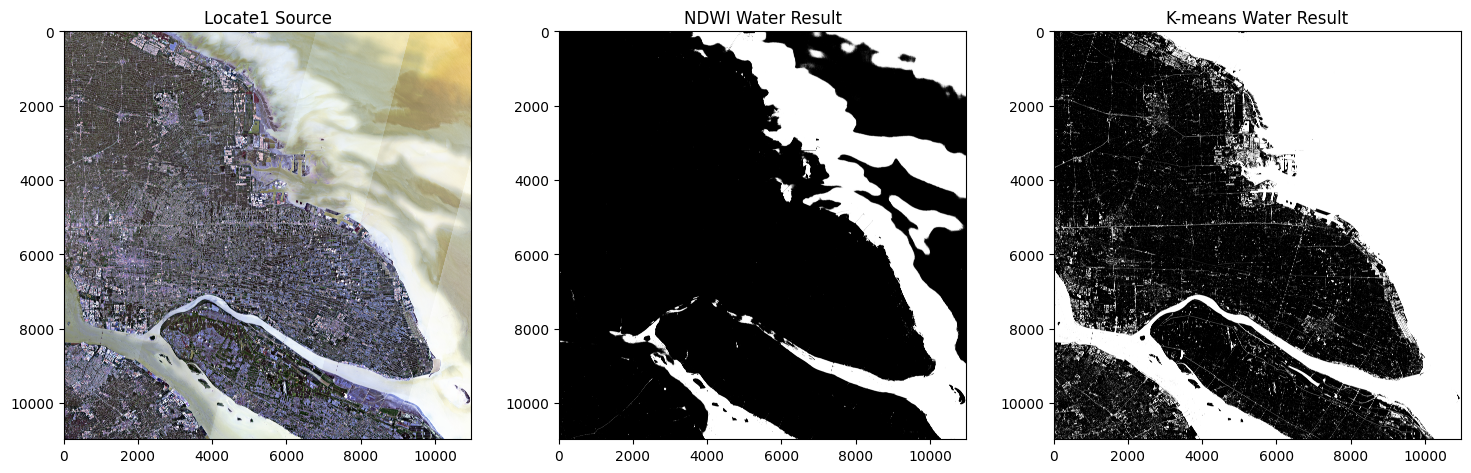

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.image import imread

# 设置图片大小和标题
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 图片1 - 渐变图
img1 = imread('/content/drive/MyDrive/20250523_remote/data/locate1/source.jpg')
im1 = axes[0].imshow(img1, cmap='viridis')
axes[0].set_title('Locate1 Source')


# 图片2 - 对角线渐变
img2 = imread('/content/drive/MyDrive/20250523_remote/data/locate1/ndwi_water_result.jpg')
im2 = axes[1].imshow(img2, cmap='grey')
axes[1].set_title('NDWI Water Result')



# 图片3 - 棋盘格
img3 = imread('/content/drive/MyDrive/20250523_remote/data/locate1/kmeans_water_result.jpg')
im3 = axes[2].imshow(img3, cmap='grey')
axes[2].set_title('K-means Water Result')


# 调整布局
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # 为总标题留出空间

# 显示图像
plt.show()

Confusion matrix calculation

Recall: 0.9994
Kappa: 0.5183
Accuracy: 0.7796


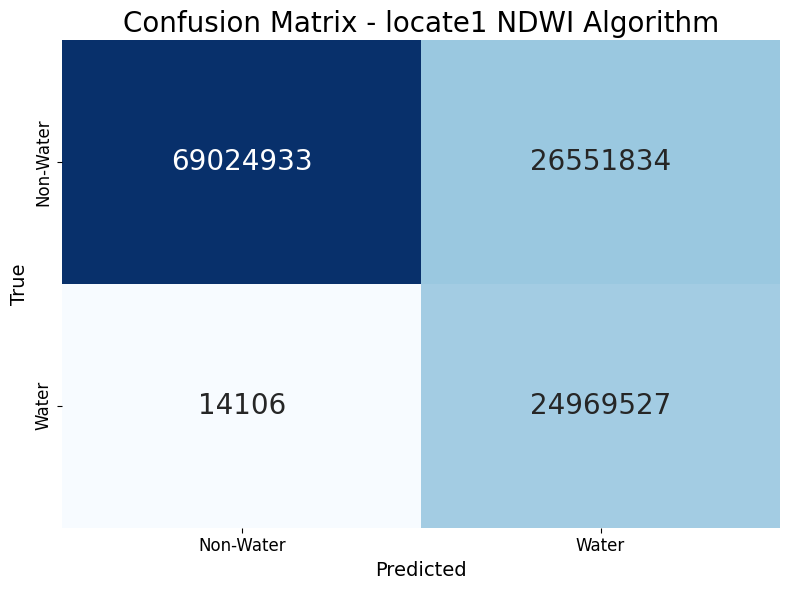

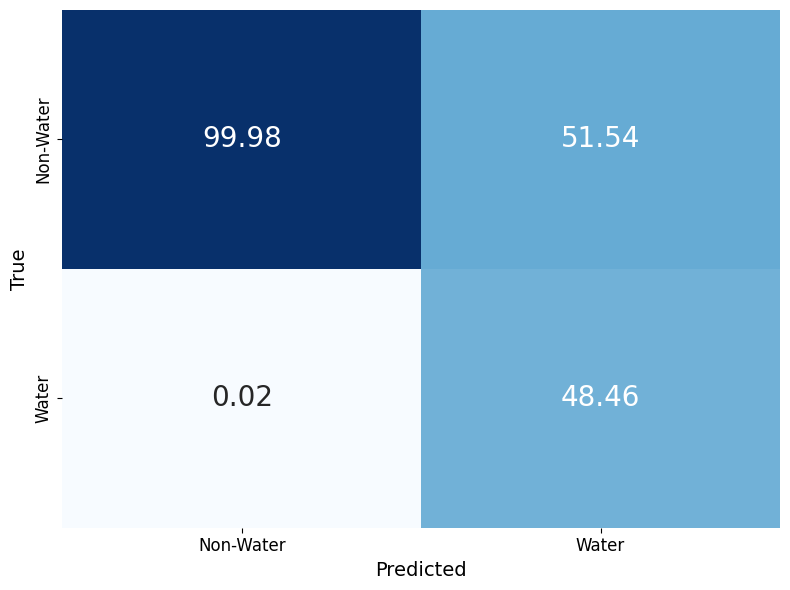

In [ ]:
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, cohen_kappa_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

file_path = "/content/drive/MyDrive/20250523_remote/data/locate1"
kmeans_img = cv2.imread(f'{file_path}/kmeans_water_result.jpg', cv2.IMREAD_GRAYSCALE)
gt_img = cv2.imread(f'{file_path}/ndwi_water_result.jpg', cv2.IMREAD_GRAYSCALE)

kmeans_binary = (kmeans_img == 255).astype(int).flatten()
gt_binary = (gt_img == 255).astype(int).flatten()

accuracy = accuracy_score(gt_binary, kmeans_binary)
recall = recall_score(gt_binary, kmeans_binary)
kappa = cohen_kappa_score(gt_binary, kmeans_binary)
cm = confusion_matrix(gt_binary, kmeans_binary)
cm_percent = cm / cm.sum(axis=0, keepdims=True) * 100

print(f"Recall: {recall:.4f}")
print(f"Kappa: {kappa:.4f}")
print(f"Accuracy: {accuracy:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Water', 'Water'], yticklabels=['Non-Water', 'Water'],
            annot_kws={"size": 20, "family": "DejaVu Sans"})
plt.title('Confusion Matrix - locate1 NDWI Algorithm', fontsize=20)
plt.xlabel('Predicted', fontsize=14, family='DejaVu Sans')
plt.ylabel('True', fontsize=14, family='DejaVu Sans')
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/20250523_remote/figure/confusion_matrix.png', dpi=300, bbox_inches='tight')
#plt.close()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['Non-Water', 'Water'], yticklabels=['Non-Water', 'Water'],
            annot_kws={"size": 20, "family": "DejaVu Sans"})
plt.xlabel('Predicted', fontsize=14, family='DejaVu Sans')
plt.ylabel('True', fontsize=14, family='DejaVu Sans')
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/20250523_remote/figure/confusion_matrix_percent.png', dpi=300, bbox_inches='tight')
#plt.close()

os.makedirs('figure', exist_ok=True)

#Locate2 Water Body Performance Analysis
As before, NDWI and K-mean data were calculated and saved.

In [ ]:
import os
import numpy as np
import rasterio
from sklearn.cluster import KMeans
import cv2

data_path = "/content/drive/MyDrive/20250523_remote/data"  # 数据路径

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    if not os.path.isdir(folder_path):
        continue

    # 读取所有波段
    bands = {'B02': None, 'B03': None, 'B04': None, 'B08': None}
    band_files = {'B02': None, 'B03': None, 'B04': None, 'B08': None}
    for file in os.listdir(folder_path):
        if file.endswith('.jp2'):
            band_name = file.split('_')[-2]
            if band_name in bands:
                with rasterio.open(os.path.join(folder_path, file)) as src:
                    bands[band_name] = src.read(1).astype(np.float32)
                    band_files[band_name] = file

    # 计算 NDWI
    with np.errstate(divide='ignore', invalid='ignore'):
        ndwi = (bands['B03'] - bands['B08']) / (bands['B03'] + bands['B08'])
        ndwi = np.nan_to_num(ndwi, nan=0.0, posinf=0.0, neginf=0.0)

    # 准备 K-means 数据（包含标准化波段和 NDWI）
    height, width = bands['B02'].shape
    data = np.stack([bands['B02'], bands['B03'], bands['B04'], bands['B08'], ndwi], axis=-1)
    data_reshaped = data.reshape(-1, 5)
    # 标准化数据
    data_reshaped = (data_reshaped - data_reshaped.mean(axis=0)) / data_reshaped.std(axis=0)

    # K-means 聚类
    kmeans = KMeans(n_clusters=2, random_state=42)  # 修改为 2 个簇
    labels = kmeans.fit_predict(data_reshaped)
    labels_image = labels.reshape(height, width)

    # 选择水体簇：比较两个簇的 NDWI 均值
    cluster_ndwi_means = [ndwi[labels_image == i].mean() for i in range(2)]
    water_cluster = np.argmax(cluster_ndwi_means)  # 选择 NDWI 均值较高的簇

    # 生成水体掩膜
    water_mask = (labels_image == water_cluster).astype(np.uint8)

    # 保存水体掩膜（TIFF）
    with rasterio.open(os.path.join(folder_path, band_files['B02'])) as src:
        profile = src.profile
        profile.update(dtype=rasterio.uint8, count=1)
        with rasterio.open(os.path.join(folder_path, 'kmeans_water_mask.tif'), 'w', **profile) as dst:
            dst.write(water_mask[None, :, :])

    # 保存 K-means 水体可视化图（水体白色，非水体黑色）
    cv2.imwrite(os.path.join(folder_path, 'kmeans_water_result.jpg'), water_mask * 255)

    # 调试：保存两个簇的掩膜图像
    for i in range(2):
        cluster_mask = (labels_image == i).astype(np.uint8) * 255
        cv2.imwrite(os.path.join(folder_path, f'cluster_{i}_mask.jpg'), cluster_mask)

    print(f"K-means 处理完成: {folder_path}，水体簇: {water_cluster}")

K-means 处理完成: /content/drive/MyDrive/20250523_remote/data/locate2，水体簇: 0


K-means 处理完成: /content/drive/MyDrive/20250523_remote/data/locate1，水体簇: 1


Generate three views for easy comparison.

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3442: DecompressionBombWarning: Image size (120560400 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


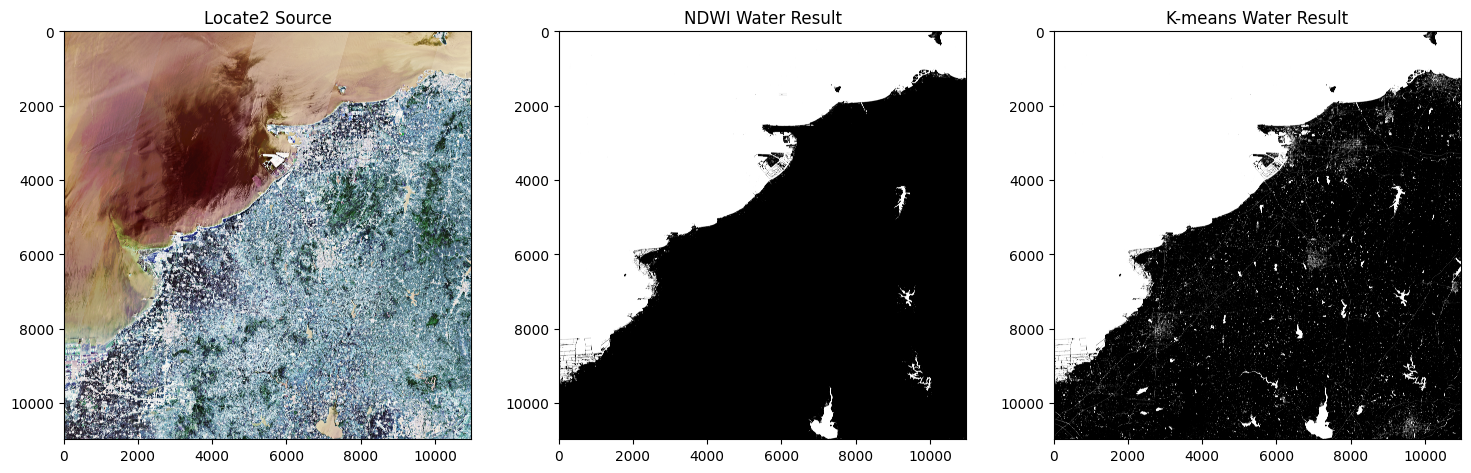

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.image import imread

# 设置图片大小和标题
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 图片1 - 渐变图
img1 = imread('/content/drive/MyDrive/20250523_remote/data/locate2/source.jpg')
im1 = axes[0].imshow(img1, cmap='viridis')
axes[0].set_title('Locate2 Source')


# 图片2 - 对角线渐变
img2 = imread('/content/drive/MyDrive/20250523_remote/data/locate2/ground_truth.jpg')
im2 = axes[1].imshow(img2, cmap='grey')
axes[1].set_title('NDWI Water Result')



# 图片3 - 棋盘格
img3 = imread('/content/drive/MyDrive/20250523_remote/data/locate2/kmeans_water_result.jpg')
im3 = axes[2].imshow(img3, cmap='grey')
axes[2].set_title('K-means Water Result')


# 调整布局
plt.tight_layout()
plt.subplots_adjust(top=0.85)  # 为总标题留出空间

# 显示图像
plt.show()

Recall: 0.9971
Kappa: 0.9572
Accuracy: 0.9794


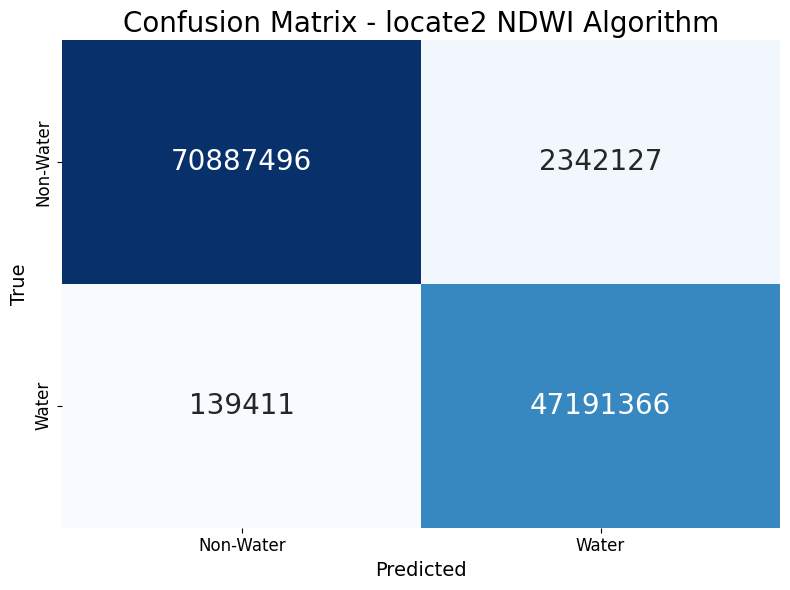

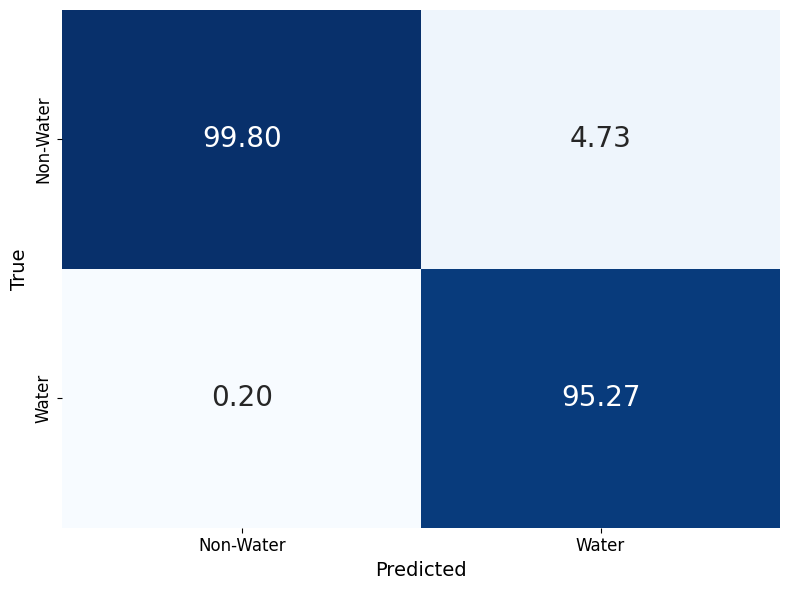

In [ ]:
import cv2
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, cohen_kappa_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os

file_path = "/content/drive/MyDrive/20250523_remote/data/locate2"
kmeans_img = cv2.imread(f'{file_path}/kmeans_water_result.jpg', cv2.IMREAD_GRAYSCALE)
gt_img = cv2.imread(f'{file_path}/ground_truth.jpg', cv2.IMREAD_GRAYSCALE)

kmeans_binary = (kmeans_img == 255).astype(int).flatten()
gt_binary = (gt_img == 255).astype(int).flatten()

accuracy = accuracy_score(gt_binary, kmeans_binary)
recall = recall_score(gt_binary, kmeans_binary)
kappa = cohen_kappa_score(gt_binary, kmeans_binary)
cm = confusion_matrix(gt_binary, kmeans_binary)
cm_percent = cm / cm.sum(axis=0, keepdims=True) * 100

print(f"Recall: {recall:.4f}")
print(f"Kappa: {kappa:.4f}")
print(f"Accuracy: {accuracy:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Non-Water', 'Water'], yticklabels=['Non-Water', 'Water'],
            annot_kws={"size": 20, "family": "DejaVu Sans"})
plt.title('Confusion Matrix - locate2 NDWI Algorithm', fontsize=20)
plt.xlabel('Predicted', fontsize=14, family='DejaVu Sans')
plt.ylabel('True', fontsize=14, family='DejaVu Sans')
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/20250523_remote/figure/confusion_matrix.png', dpi=300, bbox_inches='tight')
#plt.close()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=['Non-Water', 'Water'], yticklabels=['Non-Water', 'Water'],
            annot_kws={"size": 20, "family": "DejaVu Sans"})
plt.xlabel('Predicted', fontsize=14, family='DejaVu Sans')
plt.ylabel('True', fontsize=14, family='DejaVu Sans')
plt.tick_params(axis='both', labelsize=12)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/20250523_remote/figure/confusion_matrix_percent.png', dpi=300, bbox_inches='tight')
#plt.close()

os.makedirs('figure', exist_ok=True)

#Environmental Cost Assessment of Remote Sensing-Based Water Body Extraction

The project utilizes Sentinel-2 satellite imagery for the detection and classification of water bodies using NDWI thresholding and unsupervised K-means clustering. The environmental impact of this research is relatively moderate compared to high-energy-demanding AI applications, but it still warrants assessment and consideration for improvement.

##Hardware and Code Efficiency:
The project was executed using Python libraries such as Rasterio, OpenCV, and Scikit-learn. Efficient file handling (e.g., only loading necessary bands) and memory-optimized array operations (using np.stack, np.nan_to_num, and reshaping methods) contribute to relatively low hardware strain. However, potential improvements include batching file operations, leveraging GPU-based clustering methods for speed and energy savings, and caching intermediate results to avoid redundant computation.


##Indirect Environmental Impact:
On the positive side, the environmental benefits of this work could be significant. The ability to detect and monitor water bodies accurately supports sustainable water resource management, early flood detection, and environmental conservation efforts. As water detection becomes more efficient and automated, it could enable better policy-making and disaster mitigation strategies, indirectly contributing to environmental sustainability.

##Future Improvements:
To mitigate environmental costs further, we suggest:

Running batch processing on energy-efficient servers or cloud services with renewable energy options

Reducing disk I/O by keeping data in memory where feasible

Adopting more advanced, efficient clustering techniques (e.g., MiniBatchKMeans)

Evaluating environmental cost trade-offs when increasing model complexity (e.g., replacing K-means with deep learning)

**In conclusion, while the immediate environmental impact of this research is minimal, continuous improvements in efficiency and mindful hardware usage will ensure the sustainability of such geospatial data processing projects.**
